In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
import torch
import torch.nn as nn
from torchsummary import summary
import torch.optim as optim #optim algo
from torch.autograd import Variable #architect
from torch.optim import Adam
from torchvision import transforms as T, datasets
from torchvision.utils import make_grid #

from torch.utils.data import Dataset, DataLoader

import torch.nn.functional as F

from PIL import Image
from tqdm import tqdm
import os
from matplotlib import pyplot as plt
import numpy as np
import glob
import random

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
Classes = ['baklava','chicken_wings','crab_cakes','falafel','spaghetti_bolognese']

In [ ]:
#x= path
baklava_path = glob.glob(r"D:\2021_2022\SML\food101\baklava/*")

chicken_wings_path = glob.glob(r"D:\2021_2022\SML\food101\chicken_wings/*")

crab_cakes_path = glob.glob(r"D:\2021_2022\SML\food101\cup_cakes/*")

falafel_path = glob.glob(r"D:\2021_2022\SML\food101\falafel/*")

spaghetti_bolognese_path = glob.glob(r"D:\2021_2022\SML\food101\spaghetti_bolognese/*")

In [ ]:
#encoding
baklava_labels = [[1,0,0,0,0]]*len(baklava_path)

chicken_wings_labels = [[0,1,0,0,0]]*len(chicken_wings_path)

crab_cakes_labels = [[0,0,1,0,0]]*len(crab_cakes_path)

falafel_labels = [[0,0,0,1,0]]*len(falafel_path)

spaghetti_bolognese_labels = [[0,0,0,0,1]]*len(spaghetti_bolognese_path)

In [ ]:
train_data = baklava_path + chicken_wings_path + crab_cakes_path + falafel_path + spaghetti_bolognese_path
labels_data = baklava_labels + chicken_wings_labels + crab_cakes_labels + falafel_labels + spaghetti_bolognese_labels

In [ ]:
print(f"The number of images = {len(train_data)}")

The number of images = 5000


In [ ]:
#shuffle
c = list(zip(train_data, labels_data))
random.shuffle(c)
train_data, labels_data = zip(*c)

In [ ]:
#split
X_train, X_test, y_train, y_test = train_test_split(train_data, labels_data, test_size=0.1, random_state=42)

In [ ]:

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
print(f"size of train data {len(X_train)}")
print(f"size of valid data {len(X_valid)}")
print(f"size of test data {len(X_test)}")

size of train data 3600
size of valid data 900
size of test data 500


In [ ]:

class FoodDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform



    def __getitem__(self, index):
        path = self.paths[index]
        image = Image.open(path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        label = self.labels[index]
        label = torch.tensor(label)

        return image, label

In [ ]:
#train-tran:" object from class T"

train_transform = T.Compose([
    T.Resize(size=(224,224)),
    T.RandomRotation(degrees=(-20,+20)),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])


test_transform = T.Compose([
    T.Resize(size=(224,224)),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

valid_transform = T.Compose([
    T.Resize(size=(224,224)),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])


train_dataset = FoodDataset(X_train, y_train, train_transform)
test_dataset = FoodDataset(X_test, y_test, test_transform)
valid_dataset = FoodDataset(X_valid, y_valid, valid_transform)

In [ ]:
#visualization
def show_image(image,label,get_denormalize = True):

    image = image.permute(1,2,0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])

    if get_denormalize == True:
        image = image*std + mean
        image = np.clip(image,0,1)
        plt.imshow(image)
        plt.title(label)

    else:
        plt.imshow(image)
        plt.title(label)

def show_grid(image,title = None):

    image = image.permute(1,2,0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])

    image = image*std + mean
    image = np.clip(image,0,1)

    plt.figure(figsize=[15, 15])
    plt.imshow(image)
    if title != None:
        plt.title(title)

In [ ]:
train_batch_size = 8
test_batch_size = 8
valid_batch_size = 8

train_loader = DataLoader(train_dataset, batch_size=train_batch_size)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size)
valid_loader = DataLoader(valid_dataset, batch_size=valid_batch_size)

In [ ]:
print("No. of batches in trainloader : {}".format(len(train_loader)))
print("No. of Total examples : {}".format(len(train_loader.dataset)))

No. of batches in trainloader : 450
No. of Total examples : 3600


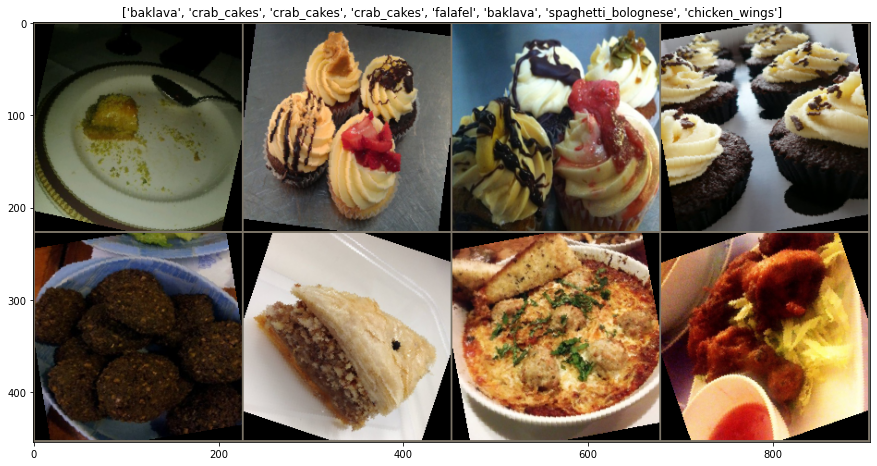

In [ ]:

dataiter = iter(train_loader)
Images , Labels = dataiter.next()

out = make_grid(Images , nrow = 4)
show_grid(out , title = [Classes[list(x).index(1)] for x in Labels])

In [ ]:
class AlexNet(nn.Module):

    def __init__(self, num_classes: int = 5):
        super(AlexNet, self).__init__()

        self.convolutional = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))

        self.linear = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        x = self.convolutional(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.linear(x)
        return torch.softmax(x,1)

In [ ]:
model = AlexNet()

In [ ]:
summary(model,input_size=(3,224,224))

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       23,296
|    └─ReLU: 2-2                         --
|    └─MaxPool2d: 2-3                    --
|    └─Conv2d: 2-4                       307,392
|    └─ReLU: 2-5                         --
|    └─MaxPool2d: 2-6                    --
|    └─Conv2d: 2-7                       663,936
|    └─ReLU: 2-8                         --
|    └─Conv2d: 2-9                       884,992
|    └─ReLU: 2-10                        --
|    └─Conv2d: 2-11                      590,080
|    └─ReLU: 2-12                        --
|    └─MaxPool2d: 2-13                   --
├─AdaptiveAvgPool2d: 1-2                 --
├─Sequential: 1-3                        --
|    └─Dropout: 2-14                     --
|    └─Linear: 2-15                      37,752,832
|    └─ReLU: 2-16                        --
|    └─Dropout: 2-17                     --
|    └─Linear: 2-18                    

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       23,296
|    └─ReLU: 2-2                         --
|    └─MaxPool2d: 2-3                    --
|    └─Conv2d: 2-4                       307,392
|    └─ReLU: 2-5                         --
|    └─MaxPool2d: 2-6                    --
|    └─Conv2d: 2-7                       663,936
|    └─ReLU: 2-8                         --
|    └─Conv2d: 2-9                       884,992
|    └─ReLU: 2-10                        --
|    └─Conv2d: 2-11                      590,080
|    └─ReLU: 2-12                        --
|    └─MaxPool2d: 2-13                   --
├─AdaptiveAvgPool2d: 1-2                 --
├─Sequential: 1-3                        --
|    └─Dropout: 2-14                     --
|    └─Linear: 2-15                      37,752,832
|    └─ReLU: 2-16                        --
|    └─Dropout: 2-17                     --
|    └─Linear: 2-18                    

In [ ]:
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0.9)
optimizer = Adam(model.parameters(),lr = 0.05)

In [ ]:
# Training with Validation
epochs = 5
min_valid_loss = np.inf
loss_train = []
loss_valid = []

for e in range(epochs):
    train_loss = 0.0
    for data, labels in train_loader:
        # Transfer Data to GPU if available
        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()

        # Clear the gradients
        optimizer.zero_grad()
        # Forward Pass
        target = model(data)
        # Find the Loss
        loss = criterion(target,torch.argmax(labels, dim=1))
        # Calculate gradients
        loss.backward()
        # Update Weights
        optimizer.step()
        # Calculate Loss
        train_loss += loss.item()

    valid_loss = 0.0
    model.eval() # Optional when not using Model Specific layer
    for data, labels in valid_loader:
        # Transfer Data to GPU if available
        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()

        # Forward Pass
        target = model(data)
        # Find the Loss
        loss = criterion(target,torch.argmax(labels, dim=1))
        # Calculate Loss
        valid_loss += loss.item()

    train_mean = train_loss / len(train_loader)
    loss_train.append(train_mean)
    valid_mean = valid_loss / len(valid_loader)
    loss_valid.append(valid_mean)

    print(f'Epoch {e+1}  Training Loss: {train_mean}  Validation Loss: {valid_mean}')

    if min_valid_loss > valid_loss:
        print(f'Validation Loss Decreased {min_valid_loss}--->{valid_loss}')
        print('Saving The Model')
        min_valid_loss = valid_loss

        # Saving State Dict
        torch.save(model.state_dict(), 'saved_model.pth')

Epoch 1  Training Loss: 1.7038982719845241  Validation Loss: 1.710142332895667
Validation Loss Decreased inf--->193.2460836172104
Saving The Model
Epoch 2  Training Loss: 1.703721488846673  Validation Loss: 1.710142332895667
Epoch 3  Training Loss: 1.703721488846673  Validation Loss: 1.710142332895667
Epoch 4  Training Loss: 1.703721488846673  Validation Loss: 1.710142332895667
Epoch 5  Training Loss: 1.703721488846673  Validation Loss: 1.710142332895667


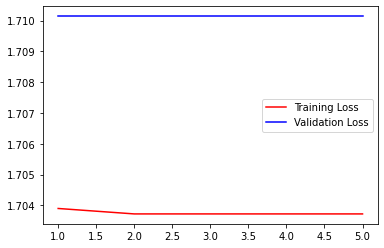

In [ ]:
plt.plot(np.linspace(1, epochs, epochs).astype(int), loss_train, 'r')
plt.plot(np.linspace(1, epochs, epochs).astype(int), loss_valid,'b')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == torch.argmax(labels, dim=1)).sum().item()

print('Accuracy of the network on test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on test images: 20 %


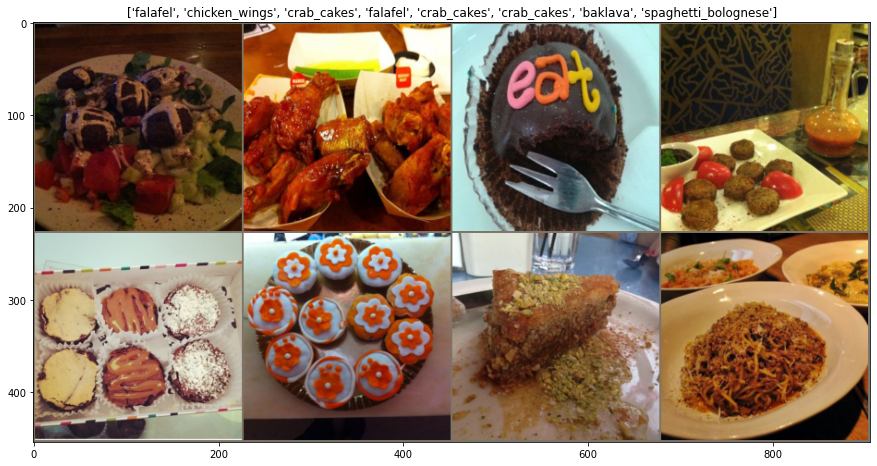

In [ ]:
dataiter = iter(test_loader)
Images , Labels = dataiter.next()

out = make_grid(Images , nrow = 4)
show_grid(out , title = [Classes[i] for i in (Labels==1).nonzero(as_tuple=True)[1]])

In [ ]:
outputs = model(Images)

In [ ]:
_,predicted = torch.max(outputs, 1)

print('Predicted:',  [Classes[predicted[j]] for j in range(8)])

print('Target   : ', [Classes[i] for i in (Labels==1).nonzero(as_tuple=True)[1]])

Predicted: ['crab_cakes', 'crab_cakes', 'crab_cakes', 'crab_cakes', 'crab_cakes', 'crab_cakes', 'crab_cakes', 'crab_cakes']
Target   :  ['falafel', 'chicken_wings', 'crab_cakes', 'falafel', 'crab_cakes', 'crab_cakes', 'baklava', 'spaghetti_bolognese']
